In [1]:
from ttt_unscuffed import *
device = "cuda"

In [2]:
random_string = "1"
training_config['random_string'] = random_string
dir_name = update_dir_name()
training_config['dir_name'] = dir_name

batch_size = training_config['batch_size']
dtype = transformer_config['dtype']
subject_ids = set([subject_id for subject_id, trial_id in training_config['train_subject_trials']+training_config['eval_subject_trials']])
subjects = {subject_id: Subject(subject_id) for subject_id in subject_ids}

model = Model(transformer_config).to(device, dtype=dtype)
electrode_embeddings = ElectrodeEmbeddings(transformer_config, subjects).to(device, dtype=dtype)

/om2/user/zaho/bfm_ic/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [5]:
!pwd

/om2/user/zaho/bfm_ic


In [10]:
import os
print(os.getcwd())



/net/vast-storage/scratch/vast/yanglab/zaho/bfm_ic


In [14]:
epoch_i = 301
model.load_state_dict(torch.load("./"+dir_name+"/model_e"+str(epoch_i)+".pth", map_location=device))
electrode_embeddings.load_state_dict(torch.load("./"+dir_name+"/model_electrode_embeddings_e"+str(epoch_i)+".pth", map_location=device))

/tmp/ipykernel_3263175/761684621.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./"+dir_name+"/model_e"+str(epoch_i)+".pth", map_locat

<All keys matched successfully>

In [15]:
batch_size = 100

In [16]:
train_dataloaders = {}
test_dataloaders = {}
for subject_id, trial_id in training_config['train_subject_trials']:
    full_dataset = BrainTreebankSubjectTrialDataset(subject_id=subject_id, trial_id=trial_id, dtype=dtype,
                                                    n_time_bins=transformer_config['max_n_time_bins'], spectrogram=transformer_config['spectrogram'])
    train_size = int((1 - training_config['p_test_chunks']) * len(full_dataset))
    indices = torch.randperm(len(full_dataset))
    train_subset = torch.utils.data.Subset(full_dataset, indices[:train_size])
    test_subset = torch.utils.data.Subset(full_dataset, indices[train_size:])
    train_dataloaders[(subject_id, trial_id)] = DataLoader(train_subset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    test_dataloaders[(subject_id, trial_id)] = DataLoader(test_subset, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    print("Loaded train and test dataloaders for subject", subject_id, "trial", trial_id)

_backbone = BrainTreebankSubjectTrialBenchmarkDatasetBackbone(subject_id, trial_id, dtype, 
                                                               transformer_config['max_n_time_bins'], spectrogram=transformer_config['spectrogram'])
eval_datasets = [
    BrainTreebankSubjectTrialBenchmarkDataset(
        subject_id=subject_id, trial_id=trial_id, dtype=dtype,
        n_time_bins=transformer_config['max_n_time_bins'], spectrogram=transformer_config['spectrogram'],
        eval_name=eval_name, backbone=_backbone
    ) for subject_id, trial_id in training_config['eval_subject_trials'] for eval_name in ["rms", "pitch", "onset", "speech"]
]
eval_dataloaders = [DataLoader(eval_datasets[i], batch_size=100, shuffle=False, pin_memory=True) for i in range(len(eval_datasets))]
print("Loaded eval dataloaders")

Loaded train and test dataloaders for subject 3 trial 1
Loaded train and test dataloaders for subject 3 trial 2
Loaded eval dataloaders


In [6]:
def eval_model(model, dataloader, test_size=0.2, token_id=-1):
    subject_id = dataloader.dataset.backbone.subject_id
    eo_store, to_store, label_store = [], [], []
    for batch_input, batch_label in dataloader:
        batch_size, n_time_bins, n_electrodes, dim_input = batch_input.shape
        permutation = torch.randperm(n_electrodes) #XXX
        batch_input = batch_input[:, :, permutation, :transformer_config['dim_input']].to(device, dtype=transformer_config['dtype'])
        batch_embeddings = electrode_embeddings(subject_id, permutation=permutation)
        eo, to = model(batch_input, batch_embeddings) # shape: (batch_size, n_time_bins, dim_output)
        if token_id == -2:
            eo = eo.reshape(batch_size, -1)  # Flatten all time steps into one vector
            to = to.reshape(batch_size, -1)
        elif token_id == -1:
            eo = eo.mean(dim=1)
            to = to.mean(dim=1)
        else:
            eo = eo[:, token_id]
            to = to[:, token_id]
        eo_store.append(eo.detach().cpu().float().numpy())
        to_store.append(to.detach().cpu().float().numpy())
        label_store.append(batch_label.detach().cpu().numpy())
    eo_store = np.concatenate(eo_store)
    to_store = np.concatenate(to_store)
    label_store = np.concatenate(label_store)

    eval_results = {}
    train_size = int(len(eo_store) * (1-test_size))
    for feature_name, feature_store in [("electrode", eo_store), ("time", to_store)]:
        regressor = sklearn.linear_model.LogisticRegression(max_iter=10000)
        regressor.fit(feature_store[:train_size], label_store[:train_size])
        regressor_pred = regressor.predict_proba(feature_store[train_size:])[:, 1]
        regressor_pred_class = regressor.predict(feature_store[train_size:])
        eval_results[f"eval/{subject_id}_{dataloader.dataset.eval_name}_{feature_name}_roc"] = sklearn.metrics.roc_auc_score(label_store[train_size:], regressor_pred)
        eval_results[f"eval/{subject_id}_{dataloader.dataset.eval_name}_{feature_name}_acc"] = sklearn.metrics.accuracy_score(label_store[train_size:], regressor_pred_class)
    return eval_results

expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(transformer_config['max_n_time_bins']-1, 1).to(device, dtype=torch.long).reshape(-1)
def calculate_loss(model, batch, subject_id):
    n_electrodes = subjects[subject_id].get_n_electrodes()
    permutation = torch.randperm(n_electrodes)

    # batch shape: (batch_size, n_time_bins, n_electrodes, SPECTROGRAM_DIMENSIONALITY or N_PER_SEG)
    batch = batch[:, :, permutation, :transformer_config['dim_input']].to(device, dtype=transformer_config['dtype'])
    batch_embeddings = electrode_embeddings(subject_id, permutation)

    # all model outputs shape: (batch_size, n_time_bins, dim_output)
    eo1, to1 = model(batch[:, :-1, :n_electrodes//2, :], batch_embeddings[:n_electrodes//2])
    eo2, to2 = model(batch[:, 1:, n_electrodes//2:, :], batch_embeddings[n_electrodes//2:])

    similarity = torch.matmul(to1[:, :].transpose(0, 1), eo2[:, :].permute(1, 2, 0)) * torch.exp(model.temperature_param)
    return nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)

def test_model(model):
    loss = 0
    n_batches = 0
    for subject_trial, dataloader in test_dataloaders.items():
        subject_id = subject_trial[0]
        for batch_i, batch in enumerate(dataloader):
            loss += calculate_loss(model, batch, subject_id)
        n_batches += len(dataloader)
    return loss / n_batches

In [32]:
dataloader_i = 3

In [33]:
import matplotlib.pyplot as plt

# Create figures for each metric across token positions
token_id_range = [-2, -1, 12]
dataloader_metric_name = eval_dataloaders[dataloader_i].dataset.eval_name
metrics = {
    f'eval/3_{dataloader_metric_name}_electrode_roc': 'Electrode ROC AUC',
    f'eval/3_{dataloader_metric_name}_electrode_acc': 'Electrode Accuracy', 
    f'eval/3_{dataloader_metric_name}_time_roc': 'Time ROC AUC',
    f'eval/3_{dataloader_metric_name}_time_acc': 'Time Accuracy'
}
token_results = {key: [] for key in metrics.keys()}
model.eval()
for token_id in token_id_range:
    # Collect results for each token position
    with torch.no_grad():
        results = eval_model(model, eval_dataloaders[dataloader_i], token_id=token_id)
        print("Evaluated for token_id", token_id)
    for metric_key, metric_name in metrics.items():
        token_results[metric_key].append(results[metric_key])

Evaluated for token_id -1
Evaluated for token_id 0
Evaluated for token_id 1
Evaluated for token_id 2
Evaluated for token_id 3
Evaluated for token_id 4
Evaluated for token_id 5
Evaluated for token_id 6
Evaluated for token_id 7
Evaluated for token_id 8
Evaluated for token_id 9
Evaluated for token_id 10
Evaluated for token_id 11
Evaluated for token_id 12
Evaluated for token_id 13
Evaluated for token_id 14
Evaluated for token_id 15
Evaluated for token_id 16
Evaluated for token_id 17
Evaluated for token_id 18
Evaluated for token_id 19
Evaluated for token_id 20
Evaluated for token_id 21
Evaluated for token_id 22
Evaluated for token_id 23


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

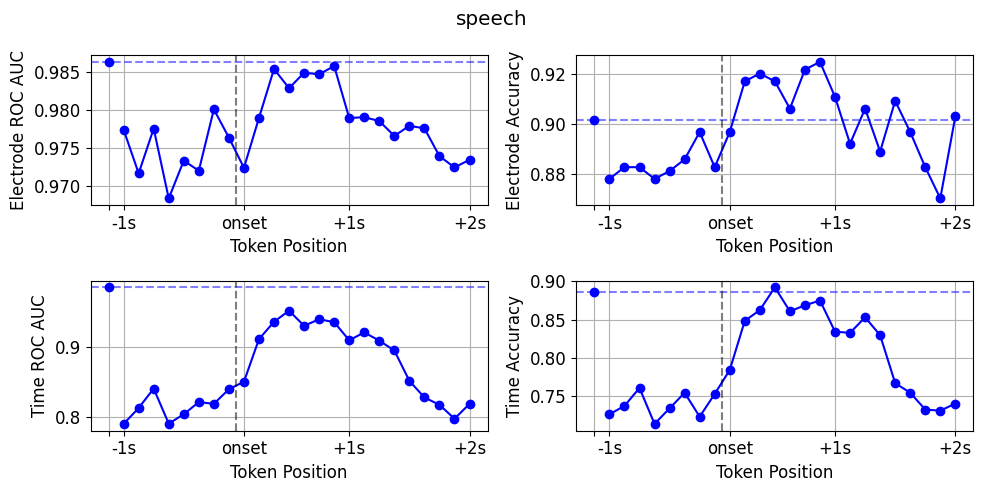

In [34]:
# Plot results
plot_color = 'blue'
plt.figure(figsize=(10, 5))
for i, (metric_key, metric_name) in enumerate(metrics.items(), 1):
    plt.subplot(2, 2, i)
    # Plot baseline point at x=-1 separately
    plt.plot([-1], [token_results[metric_key][0]], marker='o', color=plot_color)
    # Plot rest of the points connected
    plt.plot(range(0, 24), token_results[metric_key][1:], marker='o', color=plot_color)
    # Add horizontal line at baseline value
    plt.axhline(y=token_results[metric_key][0], color=plot_color, alpha=0.5, linestyle='--')
    plt.axvline(x=7.5, color="black", alpha=0.5, linestyle='--')
    plt.grid(True)
    plt.xlabel('Token Position')
    plt.xticks([-1, 0, 8, 15, 23], ['', '-1s', 'onset', '+1s', '+2s'])
    plt.ylabel(metric_name)
    plt.suptitle(dataloader_metric_name)

plt.tight_layout()
plt.savefig(f"{dir_name}/token_position_metrics_{dataloader_metric_name}.pdf")

# Analysis of feature distance per epoch

In [18]:
epoch_indices = np.unique(np.logspace(np.log10(1), np.log10(100), 30).astype(int) * 10 + 1)
epoch_indices


array([  11,   21,   31,   41,   51,   61,   71,   91,  101,  121,  141,
        171,  201,  231,  281,  321,  381,  451,  521,  621,  721,  851,
       1001])

In [19]:
avg_distances = []
avg_norms = []
epoch_indices = np.unique(np.logspace(np.log10(1), np.log10(100), 30).astype(int) * 10 + 1)
epoch_indices = [1] + list(epoch_indices)
for epoch_i in epoch_indices:
    print(f"EPOCH {epoch_i}")
    model.load_state_dict(torch.load(dir_name+"/model_e"+str(epoch_i)+".pth", map_location=device))
    electrode_embeddings.load_state_dict(torch.load(dir_name+"/model_electrode_embeddings_e"+str(epoch_i)+".pth", map_location=device))

    model.train()
    epoch_loss = 0
    epoch_avg_distance = 0
    epoch_avg_norm = 0

    # Create iterators for each dataloader
    iterators = {subject_trial: iter(dataloader) for subject_trial, dataloader in train_dataloaders.items()}
    active_dataloaders = list(train_dataloaders.keys())
    total_batches = sum(len(dl) for dl in train_dataloaders.values())
    batch_i = 0

    while active_dataloaders:
        # Randomly select a dataloader that still has batches
        subject_trial = active_dataloaders[np.random.randint(len(active_dataloaders))]
        dataloader = train_dataloaders[subject_trial]
        
        try: batch = next(iterators[subject_trial])
        except StopIteration: 
            active_dataloaders.remove(subject_trial) # Remove this dataloader from active set when depleted
            continue
        batch_i += 1

        with torch.no_grad():
            n_electrodes = subjects[subject_id].get_n_electrodes()
            permutation = torch.randperm(n_electrodes)
            # batch shape: (batch_size, n_time_bins, n_electrodes, SPECTROGRAM_DIMENSIONALITY or N_PER_SEG)
            batch = batch[:, :, permutation, :transformer_config['dim_input']].to(device, dtype=transformer_config['dtype'], non_blocking=True)
            batch_embeddings = electrode_embeddings(subject_id, permutation)
            # all shape: (batch_size, n_time_bins, dim_output)
            eo1, to1 = model(batch[:, :, :n_electrodes//2, :], batch_embeddings[:n_electrodes//2])
            eo2, to2 = model(batch[:, :, n_electrodes//2:, :], batch_embeddings[n_electrodes//2:])
            diff = to1.unsqueeze(1) - to1.unsqueeze(2) # shape: (batch_size*1*1, n_time_bins, n_time_bins, d_model)
            distances = torch.norm(diff, dim=-1) # shape: (batch_size*1*1, n_time_bins, n_time_bins)
            mask = ~torch.eye(distances.shape[1], dtype=torch.bool, device=distances.device)
            avg_distance = distances[:, mask].mean().item()
            avg_norm = torch.norm(to1, dim=-1).mean().item()
            epoch_avg_distance += avg_distance
            epoch_avg_norm += avg_norm
    epoch_avg_distance /= total_batches
    epoch_avg_norm /= total_batches
    avg_distances.append(epoch_avg_distance)
    avg_norms.append(epoch_avg_norm)

EPOCH 11


/tmp/ipykernel_3936399/3479883418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dir_name+"/model_e"+str(epoch_i)+".pth", map_location=

EPOCH 21
EPOCH 31
EPOCH 41
EPOCH 51
EPOCH 61
EPOCH 71
EPOCH 91
EPOCH 101
EPOCH 121
EPOCH 141
EPOCH 171
EPOCH 201
EPOCH 231
EPOCH 281
EPOCH 321
EPOCH 381
EPOCH 451
EPOCH 521
EPOCH 621
EPOCH 721
EPOCH 851
EPOCH 1001


In [21]:
for epoch_i in [1]:
    print(f"EPOCH {epoch_i}")
    model.load_state_dict(torch.load(dir_name+"/model_e"+str(epoch_i)+".pth", map_location=device))
    electrode_embeddings.load_state_dict(torch.load(dir_name+"/model_electrode_embeddings_e"+str(epoch_i)+".pth", map_location=device))

    model.train()
    epoch_loss = 0
    epoch_avg_distance = 0
    epoch_avg_norm = 0

    # Create iterators for each dataloader
    iterators = {subject_trial: iter(dataloader) for subject_trial, dataloader in train_dataloaders.items()}
    active_dataloaders = list(train_dataloaders.keys())
    total_batches = sum(len(dl) for dl in train_dataloaders.values())
    batch_i = 0

    while active_dataloaders:
        # Randomly select a dataloader that still has batches
        subject_trial = active_dataloaders[np.random.randint(len(active_dataloaders))]
        dataloader = train_dataloaders[subject_trial]
        
        try: batch = next(iterators[subject_trial])
        except StopIteration: 
            active_dataloaders.remove(subject_trial) # Remove this dataloader from active set when depleted
            continue
        batch_i += 1

        with torch.no_grad():
            n_electrodes = subjects[subject_id].get_n_electrodes()
            permutation = torch.randperm(n_electrodes)
            # batch shape: (batch_size, n_time_bins, n_electrodes, SPECTROGRAM_DIMENSIONALITY or N_PER_SEG)
            batch = batch[:, :, permutation, :transformer_config['dim_input']].to(device, dtype=transformer_config['dtype'], non_blocking=True)
            batch_embeddings = electrode_embeddings(subject_id, permutation)
            # all shape: (batch_size, n_time_bins, dim_output)
            eo1, to1 = model(batch[:, :, :n_electrodes//2, :], batch_embeddings[:n_electrodes//2])
            eo2, to2 = model(batch[:, :, n_electrodes//2:, :], batch_embeddings[n_electrodes//2:])
            diff = to1.unsqueeze(1) - to1.unsqueeze(2) # shape: (batch_size*1*1, n_time_bins, n_time_bins, d_model)
            distances = torch.norm(diff, dim=-1) # shape: (batch_size*1*1, n_time_bins, n_time_bins)
            mask = ~torch.eye(distances.shape[1], dtype=torch.bool, device=distances.device)
            avg_distance = distances[:, mask].mean().item()
            avg_norm = torch.norm(to1, dim=-1).mean().item()
            epoch_avg_distance += avg_distance
            epoch_avg_norm += avg_norm
    epoch_avg_distance /= total_batches
    epoch_avg_norm /= total_batches
    avg_distances.insert(0, epoch_avg_distance)
    avg_norms.insert(0, epoch_avg_norm)

EPOCH 1


/tmp/ipykernel_3936399/3925403889.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dir_name+"/model_e"+str(epoch_i)+".pth", map_location=

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

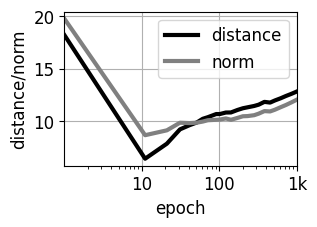

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3.0, 2))
plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})

epochs = [1] + list(epoch_indices)

plt.plot(epochs, avg_distances, color='black', linewidth=3, label='distance')
plt.plot(epochs, avg_norms, color='gray', linewidth=3, label='norm')

plt.ylabel('distance/norm')
plt.xlabel('epoch')
plt.grid(True)
plt.xscale('log')
plt.xlim(1, 1000)
plt.xticks([10, 100, 1000], ['10', '100', '1k'])
plt.legend()

plt.savefig(f"{dir_name}/distances_and_norms.pdf", bbox_inches='tight')
plt.show()

(12.747321428571428, 11.958928571428572)